# Data Imputation

### Libs

In [1]:
## libs 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

## Keras
from keras.layers import Lambda, Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

## Basic
from tqdm import tqdm_notebook as tqdm
import argparse
import os
import random
import itertools
import time

# Computation
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import MinMaxScaler

import scipy
from scipy.stats.stats import pearsonr 

## Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Network Processing
import networkx as nx
from networkx.generators import random_graphs

## node colour
orig_cmap = plt.cm.PuBu

Using TensorFlow backend.


### Supporting Function

In [2]:
## supporting functions
from support.preprocessing import sort_adj, reshape_A, calculate_A_shape, reconstruct_adjacency, pad_matrix, unpad_matrix, pad_attr, unpad_attr, prepare_in_out
from support.metrics import compute_mig, compute_mi
from support.graph_generating import generate_single_features, generate_manifold_features
from support.latent_space import vis2D, visDistr
from support.comparing import compare_manifold_adjacency, compare_topol_manifold
from support.plotting import shiftedColorMap

## graph sampling
from sampling import ForestFire, Metropolis_Hastings, Random_Walk, Snowball, Ties, Base_Samplers

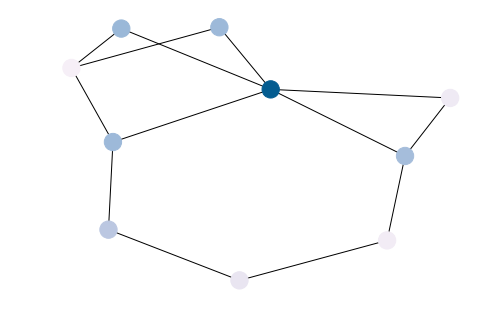

In [3]:
def get_graph(n,p,draw): 

    g = random_graphs.erdos_renyi_graph(n, p, seed=None, directed=False)

    if draw:
        f = np.random.rand(n)
        orig_cmap = plt.cm.PuBu
        fixed_cmap = shiftedColorMap(orig_cmap, start=min(f), midpoint=0.5, stop=max(f), name='fixed')
        nx.draw(g, node_color=f, font_color='white', cmap = fixed_cmap)
        plt.show()
    
    return g

g = get_graph(n = 10, p = 0.4, draw = True)

In [4]:
def generate_features(dataArgs, g, n, p):
    
        if dataArgs["feature_dependence"] == "random":
            f = np.random.rand(n, dataArgs["n_features"])                   ## float
            #F[i] = np.random.randint(2, size=(dataArgs["n_max"],dataArgs["n_features"]))   ## int
            
        if dataArgs["feature_dependence"] == "norm_degree":
            if dataArgs["n_features"] == 1:
                
                f = np.asarray([int(x[1]) for x in sorted(g.degree())])  
                f = (f) / (max(f)+1)
                f = np.reshape(f, (f.shape[-1],1))
                
                    
        if dataArgs["feature_dependence"] == "degree":
            if dataArgs["n_features"] == 1:
                
                f = np.asarray([int(x[1]) for x in sorted(g.degree())])  
                f = (f+1) / (dataArgs["n_max"]+1)
                f = np.reshape(f, (f.shape[-1],1))
                
                
        if dataArgs["feature_dependence"] == "p":  
            if dataArgs["n_features"] == 1:
                f = np.ones((n , 1)) * p
                
        return f

In [25]:
def generate_data(dataArgs): 
    
    
    ## Data ________________________________

    G = np.zeros((dataArgs["n_graphs"], *calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"])))
    F = np.zeros((dataArgs["n_graphs"], dataArgs["n_max"], dataArgs["n_features"]))
    print("feature_dependence:",dataArgs["feature_dependence"] )
    
    
    ## Generate Graph Data_______________________________

    for i in tqdm(range(0,dataArgs["n_graphs"])):
        
        ## Generate Graph Type ______________________________________________

        if dataArgs["fix_n"] == True:
            n = dataArgs["n_max"] # generate fixed number of nodes n_max
        else:
            n = random.randint(1, dataArgs["n_max"]) # generate number of nodes n between 1 and n_max and

            
        p = np.random.rand(1)  # float in range 0 - 1 
        g = get_graph(n, p, draw = False)
                     
        #nx.draw(g, cmap=plt.get_cmap('PuBu'), node_color=np.squeeze(f), font_color='white')
        #plt.show()
        
        g, a = sort_adj(g)
        a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal        
        a_transformed = reshape_A(a, diag_offset = dataArgs["diag_offset"])
        
        
        ## Generate / Load Node Features ______________________________________________
        f = generate_features(dataArgs, g, n, p)
        
        ## pad features with zeroes
        f = pad_attr(f, dataArgs)

        
        ## Build Data Arrays___________________________________________________

        F[i] = f
        G[i] = a_transformed


    ## Input and Output Size ___________________________________________________________

    input_shape, output_shape = prepare_in_out(dataArgs["diag_offset"], calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"]), F.shape)
    print("input_shape:", input_shape, ", output_shape:", output_shape)
    
    ## scale features in F for smoother training
    #scaler = MinMaxScaler()
    #scaler.fit(F)
    #F = scaler.transform(F)
    
    return G, F, input_shape,output_shape
    
dataArgs = {"n_graphs": 10000, "n_max": 12, "feature_dependence": "degree", "fix_n": False, "diag_offset": -2, "diag_value": 1, "clip": True, "n_features": 1}  #"diag_offset" - 1 == full adjacency
G, F, input_shape, output_shape = generate_data(dataArgs)

feature_dependence: degree



input_shape: ((12, 1), (12, 12, 1)) , output_shape: ((12, 1), (12, 12, 1))


## Data Imputation

In [26]:
def imput_data(imputeArgs, modelArgs, dataArgs, G, F):
        
    G_imputed = np.copy(G)
    F_imputed = np.copy(F)
    
    if imputeArgs["impute"] == "features":
        
        for i, (g,f) in enumerate(zip(G_imputed, F_imputed)):
            
            f = np.squeeze(f)
            num_features = len(f[f > 0])
            impute_num = int(imputeArgs["impute_frac"] * num_features)
            impute_f_ind = random.sample(range(num_features), impute_num)  ## impute features

            row, col = np.diag_indices(f.shape[0])

            f[impute_f_ind] = imputeArgs["impute_value"]  ## replace features
            F_imputed[i] = np.reshape(f,(f.shape[-1], 1))
        
        
    
    if imputeArgs["impute"] == "structure":
    
        for i, (g,f) in enumerate(zip(G_imputed, F_imputed)):
                        
            f = np.squeeze(f)            
            num_nodes = len(f[f > 0])
            impute_num = int(imputeArgs["impute_frac"] * num_nodes)
            impute_n_ind = random.sample(range(num_nodes), impute_num)  ## impute nodes
            
            ## remove edges of imputed nodes
            for impute_n in impute_n_ind:
                
                ## remove rows
                g[impute_n,:impute_n] = 0
                g[impute_n,impute_n+1:] = 0
                
                ## remove columns
                g[:impute_n,impute_n] = 0
                g[impute_n+1:,impute_n] = 0

            G_imputed[i] = g
        
    return G_imputed, F_imputed

# beta-VAE Model

In [27]:
## Model Setup
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

## Keras
from keras.layers import Lambda, Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, Dropout, Activation, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
import tensorflow as tf

from sklearn.model_selection import train_test_split
from support.keras_dgl.utils import *
from support.keras_dgl.layers import MultiGraphCNN


class VAE():

    # reparameterization trick
    # instead of sampling from Q(z|X), sample eps = N(0,I)
    # then z = z_mean + sqrt(var)*eps

    def sampling(self, args):
        """Reparameterization trick by sampling fr an isotropic unit Gaussian.
        # Arguments
            args (tensor): mean and log of variance of Q(z|X)
        # Returns
            z (tensor): sampled latent vector
        """

        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    
    
    def __init__(self, modelArgs, trainArgs, g_train, g_train_mod_imputed, g_test, g_test_mod_imputed, f_train, f_train_imputed, f_test, f_test_imputed):

        ## MODEL ______________________________________________________________       
            
        ## Graph Neural Network Architecture __________________________________
            
        ## 1) build encoder model____________________________________

        # build graph_conv_filters
        SYM_NORM = True
        num_filters = 2
        print("g_train shape:", g_train.shape)
        graph_conv_filters = preprocess_adj_tensor_with_identity(np.squeeze(g_train), SYM_NORM)

        # build model
        X_input = Input(shape=(f_train.shape[1], f_train.shape[2]))
        graph_conv_filters_input = Input(shape=(graph_conv_filters.shape[1], graph_conv_filters.shape[2]))

        # define inputs of features and graph topologies
        inputs = [X_input, graph_conv_filters_input]

        x = MultiGraphCNN(100, num_filters, activation='elu')([X_input, graph_conv_filters_input])
        x = Dropout(0.2)(x)
        x = MultiGraphCNN(100, num_filters, activation='elu')([x, graph_conv_filters_input])
        x = Dropout(0.2)(x)
        x = Lambda(lambda x: K.mean(x, axis=1))(x)  # adding a node invariant layer to make sure output does not depends upon the node order in a graph.
        z_mean = Dense(modelArgs["latent_dim"], name='z_mean')(x)
        z_log_var = Dense(modelArgs["latent_dim"], name='z_log_var')(x)

        # use reparameterization trick to push the sampling out as input
        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = Lambda(self.sampling, output_shape=(modelArgs["latent_dim"],), name='z')([z_mean, z_log_var])


        ## 2.1) build topology decoder model __________________________

        ## shape info needed to build decoder model
        inputs_2D_encoder = Input(shape=modelArgs["input_shape"][1], name='encoder_input')
        x_2D = inputs_2D_encoder
        for i in range(2):
            modelArgs['filters'] *= 2
            x_2D = Conv2D(filters=modelArgs['filters'], kernel_size=modelArgs['kernel_size'], activation='relu',strides=2, padding='same')(x_2D)
        shape_2D = K.int_shape(x_2D)

        latent_inputs = Input(shape=(modelArgs["latent_dim"],), name='z_sampling')
        x_2D = Dense(shape_2D[1] * shape_2D[2] * shape_2D[3], activation='relu')(latent_inputs)
        x_2D = Reshape((shape_2D[1], shape_2D[2], shape_2D[3]))(x_2D)

        for i in range(2):
            x_2D = Conv2DTranspose(filters=modelArgs['filters'], kernel_size=modelArgs['kernel_size'],activation='relu', strides=2, padding='same')(x_2D)
            modelArgs['filters'] //= 2

        topol_output = Conv2DTranspose(filters=1, kernel_size=modelArgs['kernel_size'], activation='sigmoid',padding='same', name='decoder_output')(x_2D)


        ## 2.2) build attribute decoder model __________________________

        y = Dense(4, activation='linear')(latent_inputs)
        y = Dense(10, activation='linear')(latent_inputs)
        y = Dense(modelArgs["output_shape"][0][0], activation='sigmoid')(y)
        attr_output = Reshape(modelArgs["output_shape"][0])(y)

     
    
        ## INSTANTIATE___________________________________

        encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
        encoder.summary()

        ## 2.1) instantiate topology decoder model
        topol_decoder = Model(latent_inputs, topol_output, name='topol_decoder')
        topol_decoder.summary()
        
        ## 2.2) instantiate feature decoder model
        attr_decoder = Model(latent_inputs, attr_output, name='attr_decoder')
        attr_decoder.summary()

        
        ## 3) instantiate VAE model
        attr_outputs = topol_decoder(encoder(inputs)[2])
        topol_outputs = attr_decoder(encoder(inputs)[2])
        vae = Model(inputs, [attr_outputs, topol_outputs], name='vae')

    

        ## LOSS FUNCTIONS ______________________________________
        
        def attr_loss_func(y_true, y_pred):

            ## RECONSTRUCTION LOSS_______________________            
            ## mean squared error
            attr_reconstruction_loss = mse(K.flatten(y_true), K.flatten(y_pred))
            attr_reconstruction_loss *= modelArgs["input_shape"][0][0]
                            
            ## KL LOSS _____________________________________________

            kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
            kl_loss = K.sum(kl_loss, axis=-1)
            kl_loss *= -0.5

            ## COMPLETE LOSS __________________________________________________

            #loss = K.mean(attr_reconstruction_loss + (trainArgs["beta"] * kl_loss))
            loss = K.mean(attr_reconstruction_loss)
            
            return loss
        
        
        
        def topol_loss_func(y_true, y_pred):
            
            ## RECONSTRUCTION LOSS_______________________
            ## binary cross-entropy
            topol_reconstruction_loss = binary_crossentropy(K.flatten(y_true), K.flatten(y_pred))
            topol_reconstruction_loss *= (modelArgs["input_shape"][1][0] * modelArgs["input_shape"][1][1])
                            
            ## KL LOSS _____________________________________________

            kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
            kl_loss = K.sum(kl_loss, axis=-1)
            kl_loss *= -0.5

            ## COMPLETE LOSS __________________________________________________

            loss = K.mean(topol_reconstruction_loss + (trainArgs["beta"] * kl_loss))

            return loss
        
    
        ## MODEL COMPILE______________________________________________
        
        vae.compile(optimizer='adam', loss={"attr_decoder": attr_loss_func, "topol_decoder": topol_loss_func})
        vae.summary()
        

        ## TRAIN______________________________________________

        # load the autoencoder weights

        if trainArgs["weights"] == "load":

            vae.load_weights("models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5")

        # train the autoencoder

        elif trainArgs["weights"] == "train":

            # Set callback functions to early stop training and save the best model so far
            callbacks = [EarlyStopping(monitor='val_loss', patience=trainArgs["early_stop"]), ModelCheckpoint(filepath="models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5",save_best_only=True)]
           
            vae.fit(x = [f_train_imputed, g_train_mod_imputed], y= {"attr_decoder": f_train, "topol_decoder": g_train}, epochs=trainArgs["epochs"], batch_size=trainArgs["batch_size"], callbacks=callbacks, validation_data = ([f_test_imputed, g_test_mod_imputed], {"attr_decoder": f_test, "topol_decoder": g_test}))
            vae.save_weights("models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5")
            
            self.model = (encoder, topol_decoder, attr_decoder)

### Data Split and Impute

In [28]:
trainArgs = {"beta": 1, "loss": "mse", "weights": "train", "early_stop": 1, "batch_size": 128, "epochs": 50, "data_split": 0.2}
modelArgs = {"nn_architecture": "gnn", "latent_dim": 2, "filters": 16, "kernel_size": 3, "input_shape": input_shape, "output_shape": output_shape, "param_loss": False,}
imputeArgs = {"impute": "features", "impute_frac": 1.0, "impute_value": 0.0, }

from support.keras_dgl.utils import *
from support.keras_dgl.layers import MultiGraphCNN

## Train and Validation Split _______________________________________________
g_train, g_test, f_train, f_test = train_test_split(G, F, test_size=trainArgs["data_split"], random_state=1, shuffle=True)

## impute the data
g_train_imputed, f_train_imputed = imput_data(imputeArgs, modelArgs, dataArgs, g_train, f_train)
g_test_imputed, f_test_imputed = imput_data(imputeArgs, modelArgs, dataArgs, g_test, f_test)

# build graph_conv_filters
SYM_NORM = True
g_train_mod_imputed = preprocess_adj_tensor_with_identity(np.squeeze(g_train_imputed), SYM_NORM)
g_test_mod_imputed = preprocess_adj_tensor_with_identity(np.squeeze(g_test_imputed), SYM_NORM)

data = (f_test_imputed, [g_test_mod_imputed, g_test])

In [29]:
vae = VAE(modelArgs, trainArgs, g_train, g_train_mod_imputed, g_test, g_test_mod_imputed, f_train, f_train_imputed, f_test, f_test_imputed)

models = vae.model 

g_train shape: (8000, 12, 12, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 12, 1)        0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 24, 12)       0                                            
__________________________________________________________________________________________________
multi_graph_cnn_11 (MultiGraphC (None, 12, 100)      300         input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 12, 100)      0           multi_graph

8000/8000 [==============================] - 2s 299us/step - loss: 58.4081 - topol_decoder_loss: 57.7818 - attr_decoder_loss: 0.6263 - val_loss: 58.7020 - val_topol_decoder_loss: 58.0734 - val_attr_decoder_loss: 0.6286
Epoch 9/50
8000/8000 [==============================] - 2s 287us/step - loss: 58.3793 - topol_decoder_loss: 57.7716 - attr_decoder_loss: 0.6077 - val_loss: 58.6760 - val_topol_decoder_loss: 58.0599 - val_attr_decoder_loss: 0.6161
Epoch 10/50
8000/8000 [==============================] - 2s 271us/step - loss: 58.3997 - topol_decoder_loss: 57.7990 - attr_decoder_loss: 0.6007 - val_loss: 58.8374 - val_topol_decoder_loss: 58.2251 - val_attr_decoder_loss: 0.6123


# Analysis

### Generate Single Graph

latent dimensions: 2
nodes_n: 8
node attributes: [0.55725926 0.58753824 0.3618435  0.36451325 0.50511336 0.25108308
 0.51500773 0.01181033]


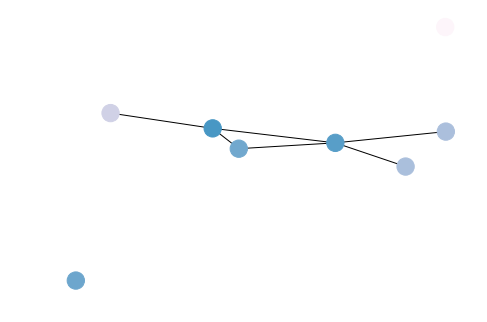

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


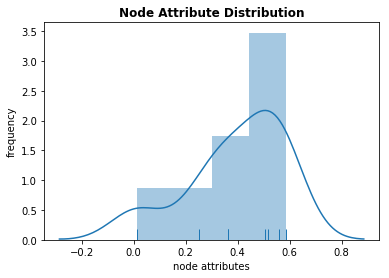

In [30]:
analyzeArgs = {"z": [0,1], "activations": [20,-2], "normalize_feature": False}
generate_single_features(analyzeArgs, modelArgs, dataArgs, models, orig_cmap)

### Generate Graph Manifold

latent dimensions: 2


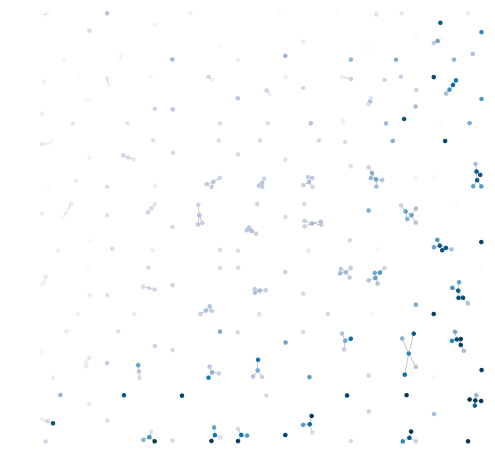

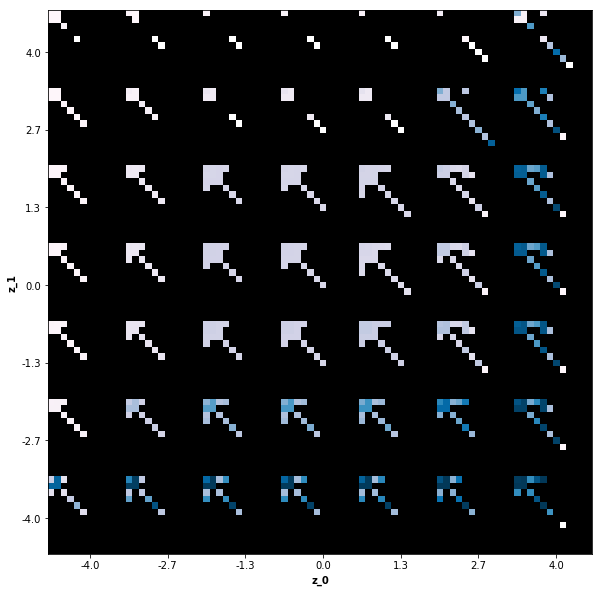

In [31]:
# range, normal, z
analyzeArgs = {"z": [0,1], "sample": "range", "act_range": [-4, 4], "act_scale": 3, "size_of_manifold": 7, "save_plots": False, "normalize_feature": False}
generate_manifold_features(analyzeArgs, modelArgs, dataArgs, models, data, orig_cmap, batch_size=trainArgs["batch_size"])

## Impaint Graphs (Extreme Cases)

impainting the features
original attributes: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


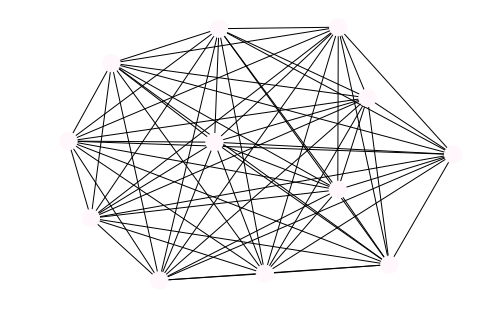

reconstructed attributes:: [0.3606372  0.32553482 0.2964049  0.26496127 0.2342247  0.20694578
 0.17876008]


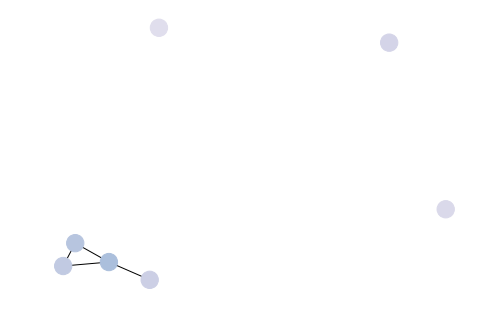

In [34]:
def impaint(analyzeArgs, imputeArgs, modelArgs, models, batch_size=128):

    print("impainting the", imputeArgs["impute"])
    
    ## unpack models__________________________
    
    encoder, topol_decoder, attr_decoder = models  # trained models
    
    ## generate feature data___________________________
    f = np.reshape([analyzeArgs["f"]] * analyzeArgs["n"], (analyzeArgs["n"], 1))
    
    ## pad features with zeroes
    f = pad_attr(f, dataArgs)

    
    ## generate graph data___________________________
    G = np.zeros((1, *calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"])))
    F = np.zeros((1, dataArgs["n_max"], dataArgs["n_features"]))

    g = get_graph(n = analyzeArgs["n"], p = analyzeArgs["p"], draw = False)
    
    g, a = sort_adj(g)
    a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal
    a = reshape_A(a, diag_offset = dataArgs["diag_offset"])
    
    G[0] = a
    F[0] = f
    
    
    ## impute data_______________________
    
    a_imputed, f_imputed = imput_data(imputeArgs, modelArgs, dataArgs, G, F)
    
    
    ## ENCODER_________________________________
    
    # build graph_conv_filters
    SYM_NORM = True
    a_imputed_mod = preprocess_adj_tensor_with_identity(np.squeeze(a_imputed), SYM_NORM)
    z_mean, _, _ = encoder.predict([f_imputed, a_imputed_mod], batch_size = batch_size)

    
    ## DECODER_________________________________    
    
    topol_decoded = topol_decoder.predict(z_mean, batch_size = batch_size)
    attr_decoded = attr_decoder.predict(z_mean, batch_size = batch_size)
    
    
    ## GRAPH RECONSTRUCTION______________________
    
    ## reconstruct graph from output
    reconstructed_a = reconstruct_adjacency(topol_decoded, dataArgs["clip"], dataArgs["diag_offset"])
    reconstructed_a, n_nodes = unpad_matrix(reconstructed_a, dataArgs["diag_value"], 0.2, dataArgs["fix_n"])
    reconstructed_g = nx.from_numpy_matrix(reconstructed_a)
    
    ## reconstruct attributes
    reconstructed_f = unpad_attr(attr_decoded[0], n_nodes, analyzeArgs, dataArgs)
    
    ## create imputed graph
    a_imputed, n_nodes = unpad_matrix(np.squeeze(a_imputed[0]), dataArgs["diag_value"], 0.2, dataArgs["fix_n"])
    g_imputed = nx.from_numpy_matrix(a_imputed)
    
    f_imputed = np.reshape(f_imputed, (f_imputed.shape[1]))
    f_imputed = f_imputed[:analyzeArgs["n"]]
    
    print("original attributes:", f_imputed)
    
    
    ## GRAPH DRAWING_____________________________
    
    ## 1) draw imputed graph
    if reconstructed_f.shape[0] > 0:
        fixed_cmap = shiftedColorMap(orig_cmap, start=min(f_imputed), midpoint=0.5, stop=max(f_imputed),name='fixed')
    else:
        fixed_cmap = shiftedColorMap(orig_cmap, start=0.5, midpoint=0.5, stop=0.5, name='fixed')    
    nx.draw(g_imputed, node_color=f_imputed, font_color='white', cmap = fixed_cmap)
    plt.show()
    
    ## 2) draw reconstructed graph
    if reconstructed_f.shape[0] > 0:
        fixed_cmap = shiftedColorMap(orig_cmap, start=min(reconstructed_f), midpoint=0.5, stop=max(reconstructed_f),name='fixed')
    else:
        fixed_cmap = shiftedColorMap(orig_cmap, start=0.5, midpoint=0.5, stop=0.5, name='fixed') 
    print("reconstructed attributes::", reconstructed_f)
    nx.draw(reconstructed_g, node_color=reconstructed_f, font_color='white', cmap = fixed_cmap)
    plt.show()

        
  ## PLOT RESULTS ________________________________________

imputeArgs["impute_frac"] = 1.0
analyzeArgs = {"n": 12, "p": 1.0, "f": 0.4, "normalize_feature": False}
impaint(analyzeArgs, imputeArgs, modelArgs, models, batch_size=trainArgs["batch_size"])